In [40]:
# 70. 単語ベクトルの和による特徴量
import gensim
import numpy as np
import re

def extract_feature(fname):
    '''
    input:  元データのファイル名
    output: なし(特徴量行列・ラベルベクトルを作成し, ファイルに保存)
    '''
    feature_matrix = np.empty((0, 300))
    label_vec = np.empty((0, 1))
    
    with open(fname, encoding='utf-8') as f:
        lines = f.readlines()
    
    for line in lines:
        # ラベルの抽出(btemを0~3に置き換え)
        label_table = str.maketrans('btem', '0123')
        label = int(line[0].translate(label_table))
        
        # 単語の抽出(' " : ; ( ) ? ! . , -の削除)
        words = line[2:].split()
        words = [re.sub('[\'":;\(\)\?\!\.\,\-]', '', word) for word in words]
        
        # 特徴量を計算
        word_vecs = np.array([model[word] for word in words if word in model])
        feature_vec = np.mean(word_vecs, axis=0)
        
        # 特徴量行列・ラベルベクトルを追加
        feature_matrix = np.vstack((feature_matrix, feature_vec))
        label_vec = np.vstack((label_vec, label))
    
    np.savetxt('data/ch08/X_'+fname[10:], feature_matrix)
    np.savetxt('data/ch08/Y_'+fname[10:], label_vec, fmt='%d')


# 単語ベクトルの準備
model = gensim.models.KeyedVectors.load_word2vec_format('data/ch07/GoogleNews-vectors-negative300.bin', binary=True)

# 特徴量行列・ラベルベクトルの作成
extract_feature('data/ch06/train.txt')
extract_feature('data/ch06/valid.txt')
extract_feature('data/ch06/test.txt')    

### 学習用データの用意

In [1]:
# 訓練・検証・評価データの用意
import torch
import numpy as np

X_train = np.loadtxt('data/ch08/X_train.txt')
X_valid = np.loadtxt('data/ch08/X_valid.txt')
X_test = np.loadtxt('data/ch08/X_test.txt')

Y_train = np.loadtxt('data/ch08/Y_train.txt')
Y_valid = np.loadtxt('data/ch08/Y_valid.txt')
Y_test = np.loadtxt('data/ch08/Y_test.txt')

# pytorch用に変換
X_train_float = torch.tensor(X_train, dtype=torch.float32)
X_valid_float = torch.tensor(X_valid, dtype=torch.float32)
X_test_float = torch.tensor(X_test, dtype=torch.float32)

Y_train_long = torch.tensor(Y_train, dtype=torch.int64)
Y_valid_long = torch.tensor(Y_valid, dtype=torch.int64)
Y_test_long = torch.tensor(Y_test, dtype=torch.int64)

In [2]:
# 乱数シードの固定
import random

def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
# 71. 単層ニューラルネットワークによる予測
import torch
import torch.nn as nn
import torch.nn.functional as F

# 単層ニューラルネットワークの定義
class OneLayerNet(nn.Module):
    def __init__(self, in_size, out_size):
        # クラスの初期化
        # 層の定義
        super().__init__()
        self.fc1 = nn.Linear(in_size, out_size)

    def forward(self, x):
        # 順伝播の計算
        y = self.fc1(x)
        return y

# 単層ニューラルネットワークの作成
fix_seed(42)
one_net = OneLayerNet(300, 4)

# y1,Yの予測
y1 = F.softmax(one_net.forward(X_train_float[0:1]), dim=1)
Y  = F.softmax(one_net.forward(X_train_float[0:4]), dim=1)

print(y1)
print(Y)

tensor([[0.2458, 0.2552, 0.2396, 0.2594]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2458, 0.2552, 0.2396, 0.2594],
        [0.2531, 0.2410, 0.2291, 0.2769],
        [0.2445, 0.2518, 0.2399, 0.2637],
        [0.2429, 0.2424, 0.2382, 0.2766]], grad_fn=<SoftmaxBackward0>)


In [4]:
# 72. 損失と勾配の計算
# モデルの定義
fix_seed(42)
one_net = OneLayerNet(300,4)
criterion = nn.CrossEntropyLoss()

# x1の損失・勾配計算
print('calculate loss and gradient for x1')

# 初期化
fix_seed(42)
nn.init.normal_(one_net.fc1.weight)

# forward
y1 = one_net.forward(X_train_float[0:1])
loss1 = criterion(y1, Y_train_long[0:1])

# backward
one_net.zero_grad()
loss1.backward()

print(f'CrossEntropyLoss: {loss1}')
print(f'W\'s gradient: {one_net.fc1.weight.grad}')


# x1,x2,x3,x4の損失・勾配計算
print('\ncalculate loss and gradient for x1,x2,x3,x4')

# 初期化
fix_seed(42)
nn.init.normal_(one_net.fc1.weight)

# forward
y2 = one_net.forward(X_train_float[0:4])
loss2 = criterion(y2, Y_train_long[0:4])

# backward
one_net.zero_grad()
loss2.backward()

print(f'CrossEntropyLoss: {loss2}')
print(f'W\'s gradient: {one_net.fc1.weight.grad}')

calculate loss and gradient for x1
CrossEntropyLoss: 2.043410301208496
W's gradient: tensor([[ 0.0026,  0.0007,  0.0028,  ...,  0.0030, -0.0002, -0.0015],
        [ 0.0290,  0.0079,  0.0313,  ...,  0.0340, -0.0026, -0.0170],
        [-0.0559, -0.0153, -0.0603,  ..., -0.0657,  0.0050,  0.0329],
        [ 0.0244,  0.0067,  0.0263,  ...,  0.0286, -0.0022, -0.0143]])

calculate loss and gradient for x1,x2,x3,x4
CrossEntropyLoss: 3.4747226238250732
W's gradient: tensor([[ 0.0019, -0.0012, -0.0016,  ..., -0.0010,  0.0047,  0.0048],
        [-0.0155, -0.0300, -0.0062,  ...,  0.0322,  0.0200, -0.0037],
        [ 0.0209,  0.0438,  0.0132,  ..., -0.0560, -0.0267,  0.0192],
        [-0.0072, -0.0126, -0.0054,  ...,  0.0248,  0.0019, -0.0203]])


In [5]:
# 73. 確率的勾配降下法による学習
import torch.optim as optim

# ハイパーパラメータの設定
max_epoch = 30
lr = 0.1

# dataloaderの定義
train_dataset = torch.utils.data.TensorDataset(X_train_float, Y_train_long)
train_dataloader = torch.utils.data.DataLoader(train_dataset)

# モデルの定義
fix_seed(42)
one_net = OneLayerNet(300,4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(one_net.parameters(), lr)

# SGDによる学習
for epoch in range(max_epoch):
    train_loss = 0
    for data in train_dataloader:
        x, y = data
        
        # forward
        predict_y = one_net.forward(x)
        loss = criterion(predict_y, y)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # 更新
        optimizer.step()
        train_loss += loss
    
    if epoch % 10 == 0:
        print(f'train loss: {train_loss/len(train_dataloader)}')

# モデルの保存
torch.save(one_net.state_dict(), 'data/ch08/73_model.pth')

train loss: 0.4072670638561249
train loss: 0.24594633281230927
train loss: 0.23610737919807434


In [47]:
# 74. 正解率の計測
from sklearn.metrics import accuracy_score

# 正解率の計測
# 複数回利用するため, 関数にまとめる
def measure_accuracy(model, x,y):
    '''
    input : model, x(tensor), y(ndarray)
    output: accuracy
    '''
    predict = model.forward(x)
    predict_label = torch.max(predict, axis=1)[1].detach().numpy()
    accuracy = accuracy_score(predict_label, y)
    
    return accuracy


# モデルの読み込み
one_net = OneLayerNet(300,4)
one_net.load_state_dict(torch.load('data/ch08/73_model.pth'))


# 学習データの正解率
print('measure accuracy of train data')
train_accuracy = measure_accuracy(one_net, X_train_float, Y_train)
print(f'accuracy: {train_accuracy}')

# 評価データの正解率
print('measure accuracy of test data')
test_accuracy = measure_accuracy(one_net, X_test_float, Y_test)
print(f'accuracy: {test_accuracy}')

measure accuracy of train data
accuracy: 0.9169786596780232
measure accuracy of test data
accuracy: 0.8952095808383234


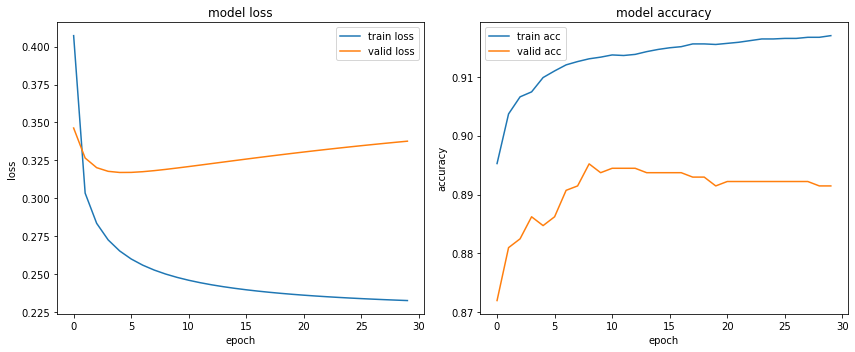

In [48]:
# 75. 損失と正解率のプロット
import matplotlib.pyplot as plt

# ハイパーパラメータの設定
max_epoch = 30
lr = 0.1

# モデルの定義
fix_seed(42)
one_net = OneLayerNet(300,4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(one_net.parameters(), lr)

# loss, accの記録
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

# SGDによる学習
for epoch in range(max_epoch):
    train_loss = 0
    valid_loss = 0
    for data in train_dataloader:
        x, y = data
        
        # forward
        predict_y = one_net.forward(x)
        loss = criterion(predict_y, y)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # 更新
        optimizer.step()
        train_loss += loss
    
    # loss, accの記録
    valid_loss = criterion(one_net.forward(X_valid_float), Y_valid_long)
    train_losses.append(train_loss/len(train_dataloader))
    valid_losses.append(valid_loss)
    train_accs.append(measure_accuracy(one_net, X_train_float, Y_train))
    valid_accs.append(measure_accuracy(one_net, X_valid_float, Y_valid))


# グラフにプロット
epoch = [i for i in range(max_epoch)]

train_losses_np = [train_loss.detach().numpy() for train_loss in train_losses]
valid_losses_np = [valid_loss.detach().numpy() for valid_loss in valid_losses]

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(epoch, train_losses_np, label='train loss')
ax1.plot(epoch, valid_losses_np, label='valid loss')
ax2.plot(epoch, train_accs, label='train acc')
ax2.plot(epoch, valid_accs, label='valid acc')
ax1.legend()
ax2.legend()
ax1.set_title('model loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax2.set_title('model accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')

fig.tight_layout()
plt.show()

In [49]:
# 76. チェックポイント
# ハイパーパラメータの設定
max_epoch = 30
lr = 0.1

# モデルの定義
fix_seed(42)
one_net = OneLayerNet(300,4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(one_net.parameters(), lr)

# SGDによる学習
for epoch in range(max_epoch):
    for data in train_dataloader:
        x, y = data
        
        # forward
        predict_y = one_net.forward(x)
        loss = criterion(predict_y, y)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # 更新
        optimizer.step()
    
    # チェックポイントの書き出し(10エポックごとに書き出し)
    if epoch % 10 == 9:
        fname = f'data/ch08/76_model_ep{epoch+1}.cpt'
        torch.save(one_net.state_dict(), fname)

In [64]:
# 77. ミニバッチ化
import time

def batch_learning(batch_size):
    '''
    input : batch_size
    output: elapsed_time, valid_acc
    '''
    # モデルの定義
    fix_seed(42)
    one_net = OneLayerNet(300,4)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(one_net.parameters(), lr)
    
    # ミニバッチ化
    train_dataloader_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
    
    # 開始時間
    start_time = time.process_time()
    
    # SGDによる学習
    for epoch in range(max_epoch):
        for data in train_dataloader_batch:
            x, y = data

            # forward
            predict_y = one_net.forward(x)
            loss = criterion(predict_y, y)

            # backward
            optimizer.zero_grad()
            loss.backward()

            # 更新
            optimizer.step()

    # 終了時間, 経過時間
    end_time = time.process_time()
    elapsed_time = end_time - start_time
    
    # 検証データの正解率
    valid_acc = measure_accuracy(one_net, X_valid_float, Y_valid)
    
    return elapsed_time, valid_acc

# ハイパーパラメータの設定
max_epoch = 10
lr = 0.1

# batch_size=2,4,8,32について検証データの正解率と経過時間を記録
elapsed_times = []
valid_accs = []
Bs = [2,4,8,16,32]

for batch_size in Bs:
    elapsed_time, valid_acc = batch_learning(batch_size)
    elapsed_times.append(elapsed_time)
    valid_accs.append(valid_acc)

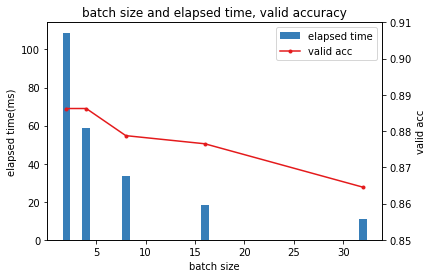

In [66]:
# グラフの描写
from matplotlib import cm

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# 色の設定
color_1 = cm.Set1.colors[1]
color_2 = cm.Set1.colors[0]

# accuracyとtimeのプロット
ax1.bar(Bs, elapsed_times, color=color_1, label='elapsed time')
ax2.plot(Bs, valid_accs, color=color_2, label='valid acc', marker='.')

ax1.set_ylabel('elapsed time(ms)')
ax2.set_ylabel('valid acc')
ax1.set_xlabel('batch size')
ax2.set_ylim(0.85, 0.91)

# 凡例をまとめて出力
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()

ax1.legend(handler1+handler2, label1+label2)

plt.title('batch size and elapsed time, valid accuracy')
plt.show()

### GPU使用の準備

In [76]:
# GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 検証データをGPUに載せる
X_valid_float_gpu = X_valid_float.to(device)
Y_valid_long_gpu = Y_valid_long.to(device)

# GPU上で正解率を計算
def measure_accuracy_gpu(model, x, y):
    '''
    input : model(gpu), x(tensor,gpu), y(tensor,gpu)
    output: accuracy
    '''
    predict_label = torch.max(model.forward(x), 1)[1]
    accuracy = sum(y==predict_label)/len(y)
    
    return accuracy

# GPU上のdataset
gpu_train_dataset = torch.utils.data.TensorDataset(X_train_float.to(device), Y_train_long.to(device))

In [80]:
# 78. GPU上での学習
def gpu_batch_learning(batch_size):
    '''
    input : batch_size
    output: elapsed_time, valid_acc
    '''
    # モデルの定義
    fix_seed(42)
    one_net = OneLayerNet(300,4).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(one_net.parameters(), lr)
    
    # ミニバッチ化
    gpu_train_dataloader_batch = torch.utils.data.DataLoader(gpu_train_dataset, batch_size=batch_size, drop_last=True)
    
    # 開始時間
    start_time = time.process_time()
    
    # SGDによる学習
    for epoch in range(max_epoch):
        for data in gpu_train_dataloader_batch:
            x, y = data

            # forward
            predict_y = one_net.forward(x)
            loss = criterion(predict_y, y)

            # backward
            optimizer.zero_grad()
            loss.backward()

            # 更新
            optimizer.step()

    # 終了時間, 経過時間
    end_time = time.process_time()
    elapsed_time = end_time - start_time
    
    # 検証データの正解率
    valid_acc = measure_accuracy_gpu(one_net, X_valid_float_gpu, Y_valid_long_gpu)
    
    return elapsed_time, valid_acc

# ハイパーパラメータの設定
max_epoch = 10
lr = 0.1
Bs = [2,4,8,16,32]

# SGDによる学習
# B=2,4,8,16,32について検証データの正解率と経過時間を記録
elapsed_times2 = []
valid_accs2_gpu = []

for batch_size in Bs:
    elapsed_time, valid_acc = gpu_batch_learning(batch_size)
    elapsed_times2.append(elapsed_time)
    valid_accs2_gpu.append(valid_acc)

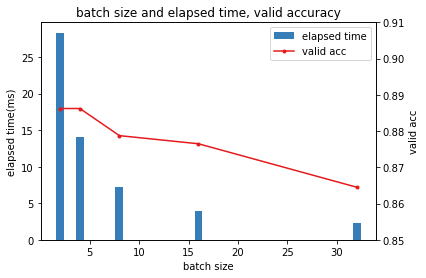

In [82]:
# グラフの描写
# データをcpu上に載せる
valid_accs2 = [valid_acc.cpu() for valid_acc in valid_accs2_gpu]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# 色の設定
color_1 = cm.Set1.colors[1]
color_2 = cm.Set1.colors[0]

# accuracyとtimeのプロット
ax1.bar(Bs, elapsed_times2, color=color_1, label='elapsed time')
ax2.plot(Bs, valid_accs2, color=color_2, label='valid acc', marker='.')

ax1.set_ylabel('elapsed time(ms)')
ax2.set_ylabel('valid acc')
ax1.set_xlabel('batch size')
ax2.set_ylim(0.85, 0.91)

# 凡例をまとめて出力
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()

ax1.legend(handler1+handler2, label1+label2)

plt.title('batch size and elapsed time, valid accuracy')
plt.show()

In [18]:
# 79. 多層ニューラルネットワーク
class TwoLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(300, 10)
        self.fc2 = nn.Linear(10, 4)
    
    # 順伝播
    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

def two_layer_net_learn(max_epoch=20, lr=0.1, B=16):
    '''
    input :max_epoch, learning_late, B(bach_size)
    output:valid_accuracys
    '''
    valid_accs = []
    
    # nnの用意
    fix_seed(42)
    two_layer_net = TwoLayerNet().to(device)
    
    # ミニバッチ化
    gpu_train_data = GPUTrainDataSet()
    gpu_train_data_loader = torch.utils.data.DataLoader(gpu_train_data, batch_size=B, shuffle=True, drop_last=True)
    
    # 目的関数の設定, SGD用意
    criterion = nn.functional.cross_entropy
    optimizer = optim.SGD(two_layer_net.parameters(), lr)
    
    for epoch in range(max_epoch):
        for X, Y in gpu_train_data_loader:
            # 順伝播の計算
            predict_Y = two_layer_net(X)
            Loss = criterion(predict_Y, Y)
            
            # 勾配の計算
            optimizer.zero_grad()
            Loss.backward()
            
            # 更新
            optimizer.step()
        
        # accuracyの計算
        predict_Y_valid = torch.argmax(two_layer_net(X_valid_float_gpu), dim=1)
        valid_acc = torch.sum(predict_Y_valid == Y_valid_long_gpu) * 1.0 / len(Y_valid_long_gpu)
        valid_accs.append(valid_acc)
    
    return valid_accs

# ハイパーパラメータの設定
max_epoch = 100
lr = 0.1
B = 32

# SGDによる学習
valid_accuracys_gpu = two_layer_net_learn(max_epoch, lr, B)

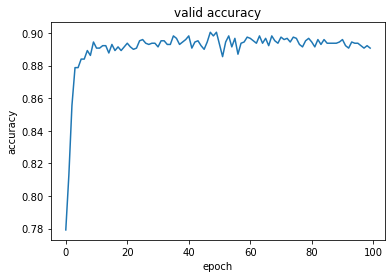

In [19]:
# グラフの描写
# データをcpu上に載せる
valid_accuracys_cpu = [valid_acc.cpu() for valid_acc in valid_accuracys_gpu]

epoch = [i for i in range(max_epoch)]

plt.plot(epoch, valid_accuracys_cpu)
plt.title('valid accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [20]:
# max accuracyとその時のepoch数
print(f'max accuracy: {np.max(valid_accuracys_cpu)}')
print(f'epoch: {np.argmax(valid_accuracys_cpu)}')

max accuracy: 0.9004491567611694
epoch: 47
